## DDQN in Hockey Enviroment - Training

Train a DDQN on various Hockey env. modes

Base DQN implementation adapted from HW7

In [ ]:
import os
import sys
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Adding the parent directory to the path to enable importing
root_dir = os.path.dirname(os.path.abspath("../"))
if root_dir not in sys.path:
    sys.path.append(root_dir)

import DDQN.DDQN as ddqn
from DDQN.dqn_action_space import CustomActionSpace
from DDQN.DQN import TargetDQNAgent, DoubleDQNAgent
from DDQN.DDQN import DuelingDQNAgent, DoubleDuelingDQNAgent
from DDQN.dqn_trainer import Stats, Round, CustomHockeyMode, train_ddqn_agent_torch
    
import hockey.hockey_env as h_env


reload(h_env)
reload(ddqn)

/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'DDQN.DDQN' from '/home/kivanc/ders/RL/project/RL-Hockey/DDQN/DDQN.py'>

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Training

### Environment & Agent Initialization

In [22]:
env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

In [4]:
DISCOUNT = 0.90
EPS = 0.2
UPDATE_TARGET_FREQ = 20
TAU = 1e-4
STATE_PATH = "./models/hockey_double-ddqn_dev/"

In [5]:
agent_player = DoubleDuelingDQNAgent(
    env.observation_space,
    CustomActionSpace(),
    discount=DISCOUNT,
    epsilon=EPS,
    hidden_sizes=[2048],
    hidden_sizes_A=[2048, 2048],
    hidden_sizes_V=[2048, 2048],
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU,
    use_torch=True
)

In [6]:
agent_player = DoubleDQNAgent(
    env.observation_space,
    env.discrete_action_space,
    discount=DISCOUNT,
    epsilon=EPS,
    hidden_sizes=[2048],
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU,
    use_torch=True
)

In [6]:
agent_opp_weak = h_env.BasicOpponent(weak=True)
agent_opp_strong = h_env.BasicOpponent(weak=False)

In [7]:
# For the visualisation of the training progress
# Be sure to use a new instance for each training session, otherwise the stats will be
# accumulated.
stats = Stats()

### Training

Choose a training scheme:

In [8]:
rounds = [
    Round(100, agent_opp_weak, CustomHockeyMode.NORMAL),
    Round(200, agent_opp_strong, CustomHockeyMode.NORMAL),
    Round(50, agent_opp_weak, CustomHockeyMode.SHOOTING),
    Round(50, agent_opp_weak, CustomHockeyMode.DEFENSE),
    Round(100, agent_opp_strong, CustomHockeyMode.RANDOM_SHOOTING_DEFENSE),
    Round(100, agent_opp_strong, CustomHockeyMode.RANDOM_ALL),
]

In [16]:
rounds = [
    Round(1_000, agent_opp_strong, CustomHockeyMode.RANDOM_ALL),
]

In [9]:
rounds = [
    Round(10, agent_opp_weak, CustomHockeyMode.NORMAL),
    Round(20, agent_opp_strong, CustomHockeyMode.NORMAL)
]

Execute training:

In [17]:
train_ddqn_agent_torch(
    agent_player,
    env,
    model_dir=STATE_PATH,
    max_steps=1000,
    rounds=rounds,
    stats=stats,
    eval_opps_dict={},
    eval_freq=-1,
    ddqn_iter_fit=32,
    print_freq=100,
    tqdm=tqdm,
    verbose=True,
    wandb_hparams=None
)

Begin round 1 with mode RANDOM_ALL for 1000 episodes


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1 | Return: -40.83189042964737 | Loss: 0.025644874200224876 | Done in 251 steps
Episode 101 | Return: -14.687333365873574 | Loss: 0.06814592331647873 | Done in 182 steps
Episode 201 | Return: -30.308886116632095 | Loss: 0.013713394291698933 | Done in 251 steps
Episode 301 | Return: -10.883729202366855 | Loss: 0.06012149155139923 | Done in 14 steps
Episode 401 | Return: -17.85585614205059 | Loss: 0.012274151667952538 | Done in 209 steps
Episode 501 | Return: 9.56025376066694 | Loss: 0.06652620434761047 | Done in 32 steps
Episode 601 | Return: -19.59949830391363 | Loss: 0.015661019831895828 | Done in 187 steps
Episode 701 | Return: -13.547342450285498 | Loss: 0.02008950710296631 | Done in 87 steps
Episode 801 | Return: -18.24147818083186 | Loss: 0.025843558833003044 | Done in 222 steps
Episode 901 | Return: -20.27830930833199 | Loss: 0.05398014932870865 | Done in 251 steps
Episode 1000 | Return: -15.59117969796545 | Loss: 0.023710114881396294 | Done in 112 steps


## Agent Model Saving

In [ ]:
agent_player.save_state(os.path.join(STATE_PATH), "final.ckpt")

## Visualization

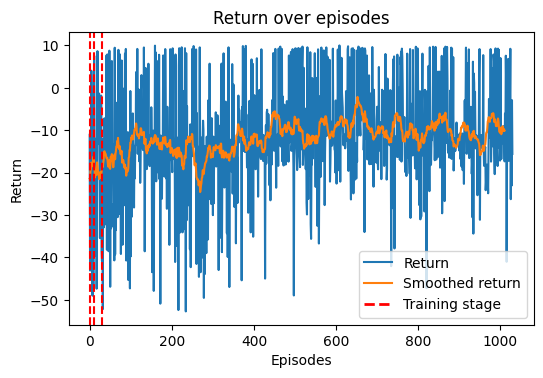

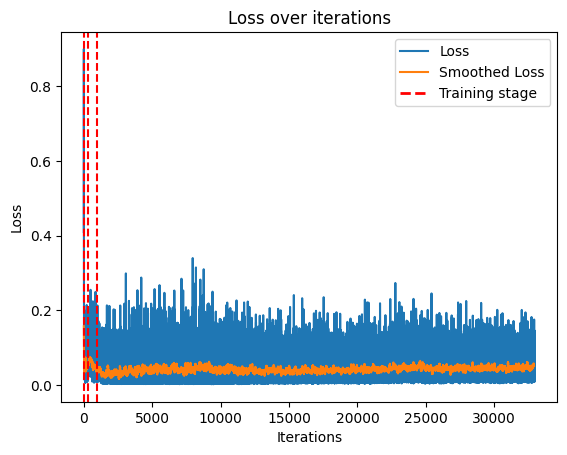

In [19]:
returns_np = np.asarray(stats.returns)
losses_np = np.asarray(stats.losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(returns_np[:,1], label="Return")
plt.plot(running_mean(returns_np[:,1],20), label="Smoothed return")
for xc in stats.returns_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Return over episodes")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

plt.figure()
plt.plot(losses_np, label="Loss")
plt.plot(running_mean(losses_np, 50), label="Smoothed Loss")
for xc in stats.losses_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

### Rendered Demonstration Against Strong Opponent

For a more detailed evaluation, refer to `ddqn-hockey-eval.ipynb`.

In [23]:
obs_buffer = []
reward_buffer = []
obs, _ = env.reset()
obs_opp = env.obs_agent_two()

done = False
trunc = False
step = 0
while not (done or trunc):
    step += 1
    env.render()
    
    a1_discr = agent_player.act(obs)
    a1 = CustomActionSpace.discrete_to_continuous(a1_discr)
    a2 = agent_opp_strong.act(obs_opp)

    obs, r, done, trunc, _ = env.step(np.hstack([a1, a2]))
    obs_buffer.append(obs)
    reward_buffer.append(r)

    obs_opp = env.obs_agent_two()

    if done or trunc:
        print(f"Episode done in {step} steps")
        break

Episode done in 149 steps


In [24]:
env.close()